# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


# Imports


In [24]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [25]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [26]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [27]:
path = '../../mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [28]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [29]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# 싸이너스 노이즈 시각화

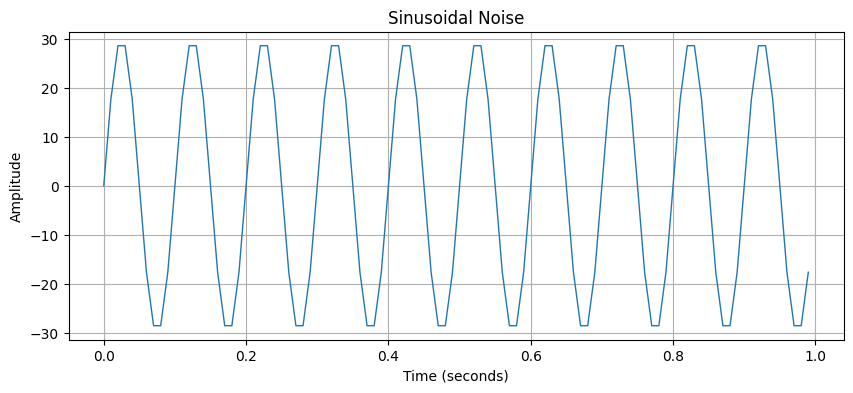

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 노이즈 파라미터 설정
frequency = 10  # 노이즈 주파수
amplitude = 30  # 노이즈 진폭
phase = 0  # 노이즈 위상

# 시간 범위 설정
t = np.arange(0, 1,0.01)  # 1초 동안의 데이터를 0.001초 간격으로 생성

# 싸이너스 노이즈 생성
sinusoid_noise = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# 그래프로 시각화
plt.figure(figsize=(10, 4))
plt.plot(t, sinusoid_noise)
plt.title("Sinusoidal Noise")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Data Extraction and Preprocessing

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\root\AppData\Local\Temp\ipykernel_3544\1707808248.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\root\AppData\Local\Temp\ipykernel_3544\1707808248.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\root\AppData\Local\Temp\ipykernel_3544\1707808248.py:30: SyntaxWarning: "is" with a literal. Did you me

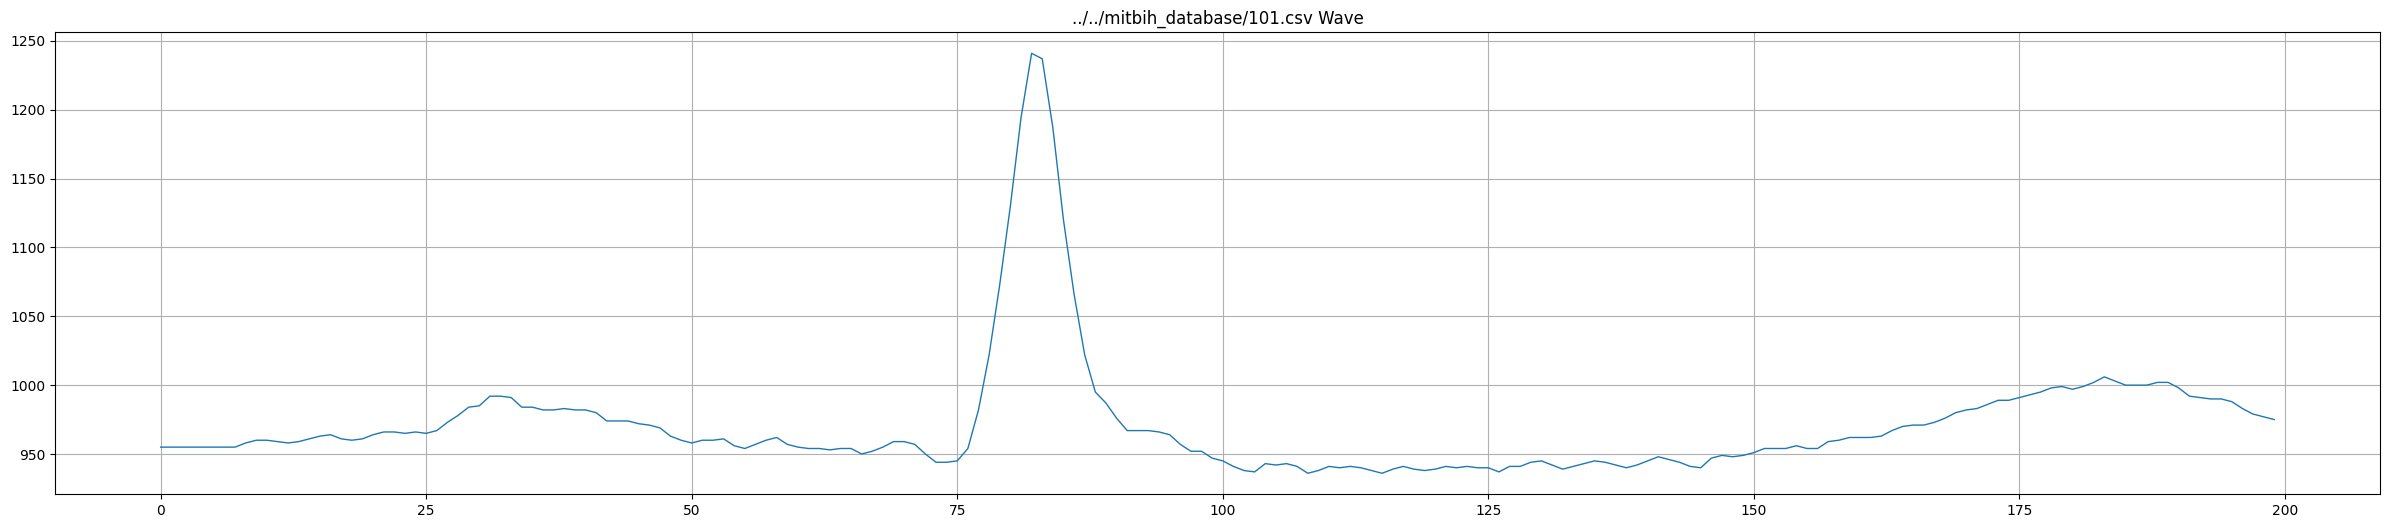

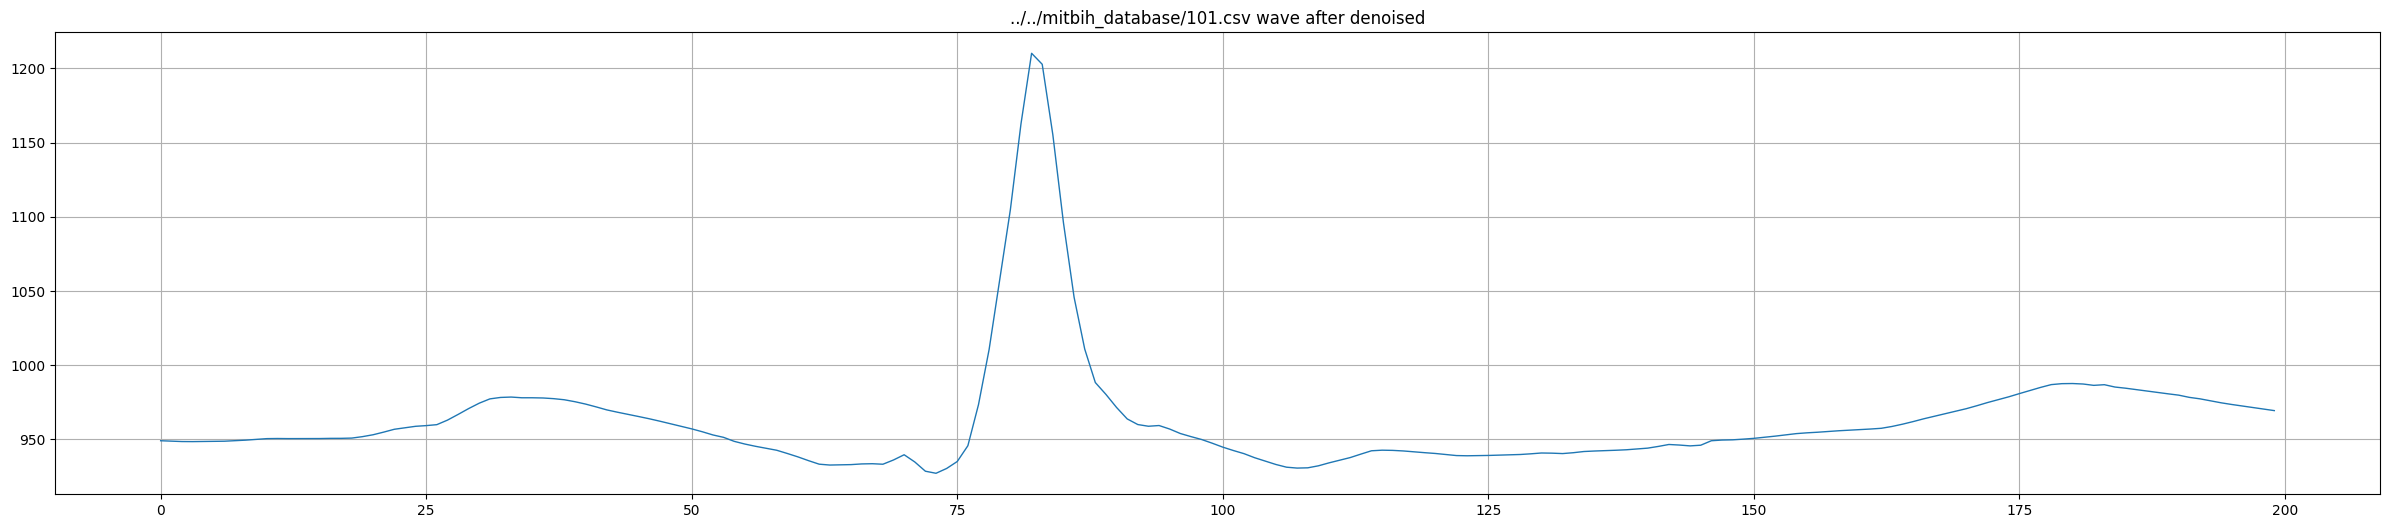

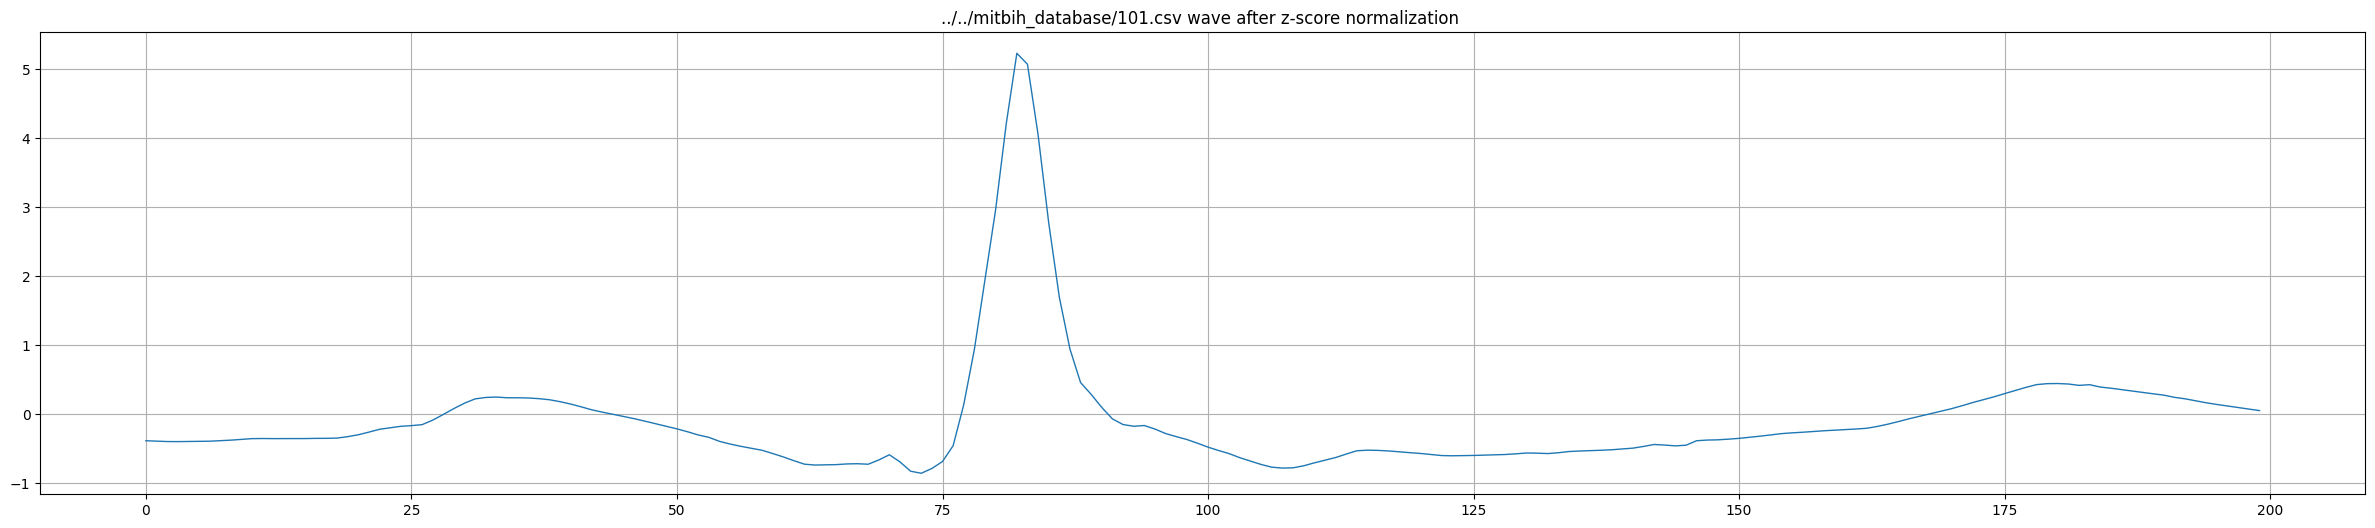

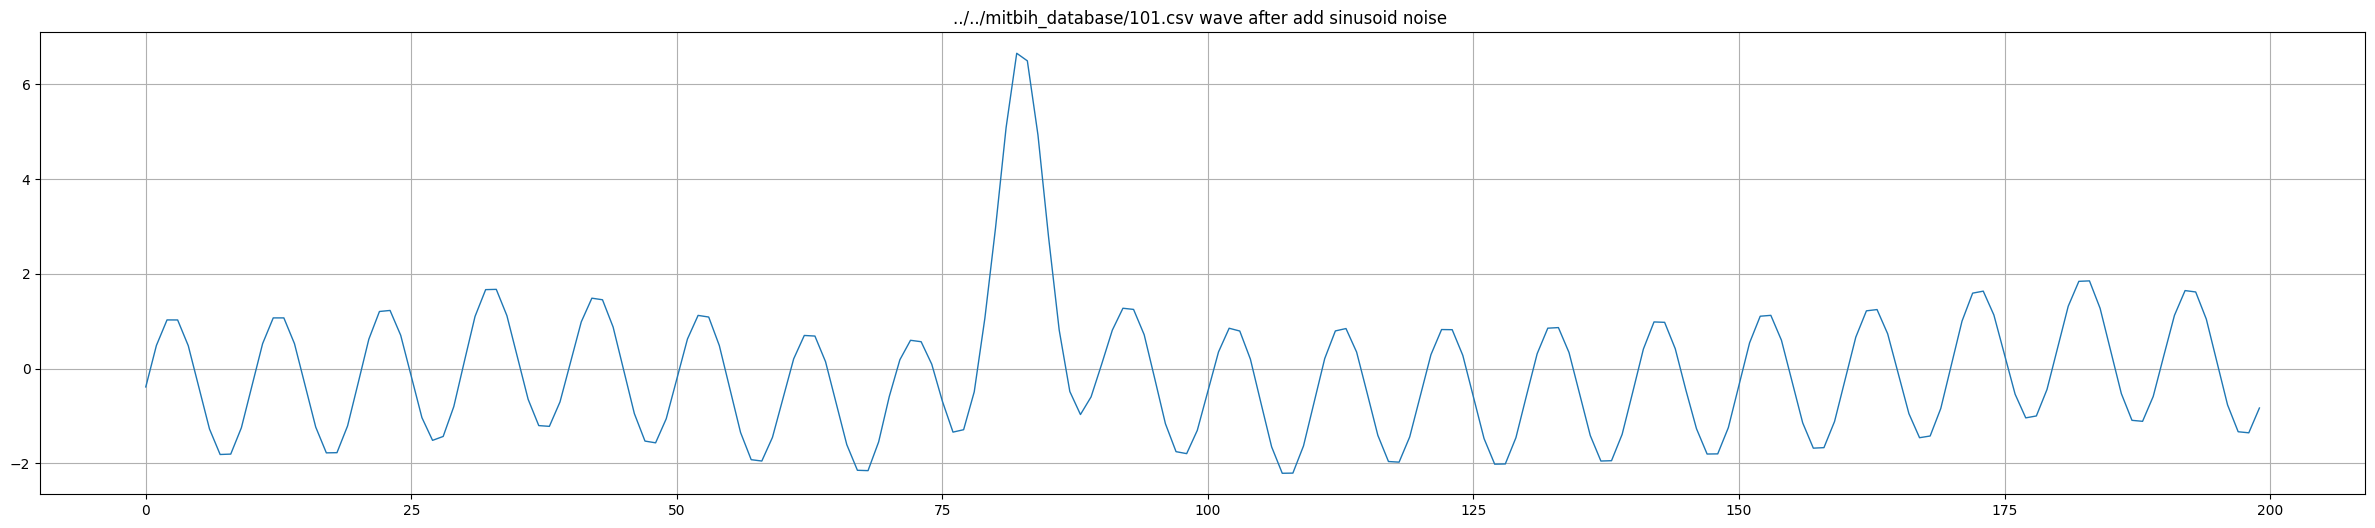

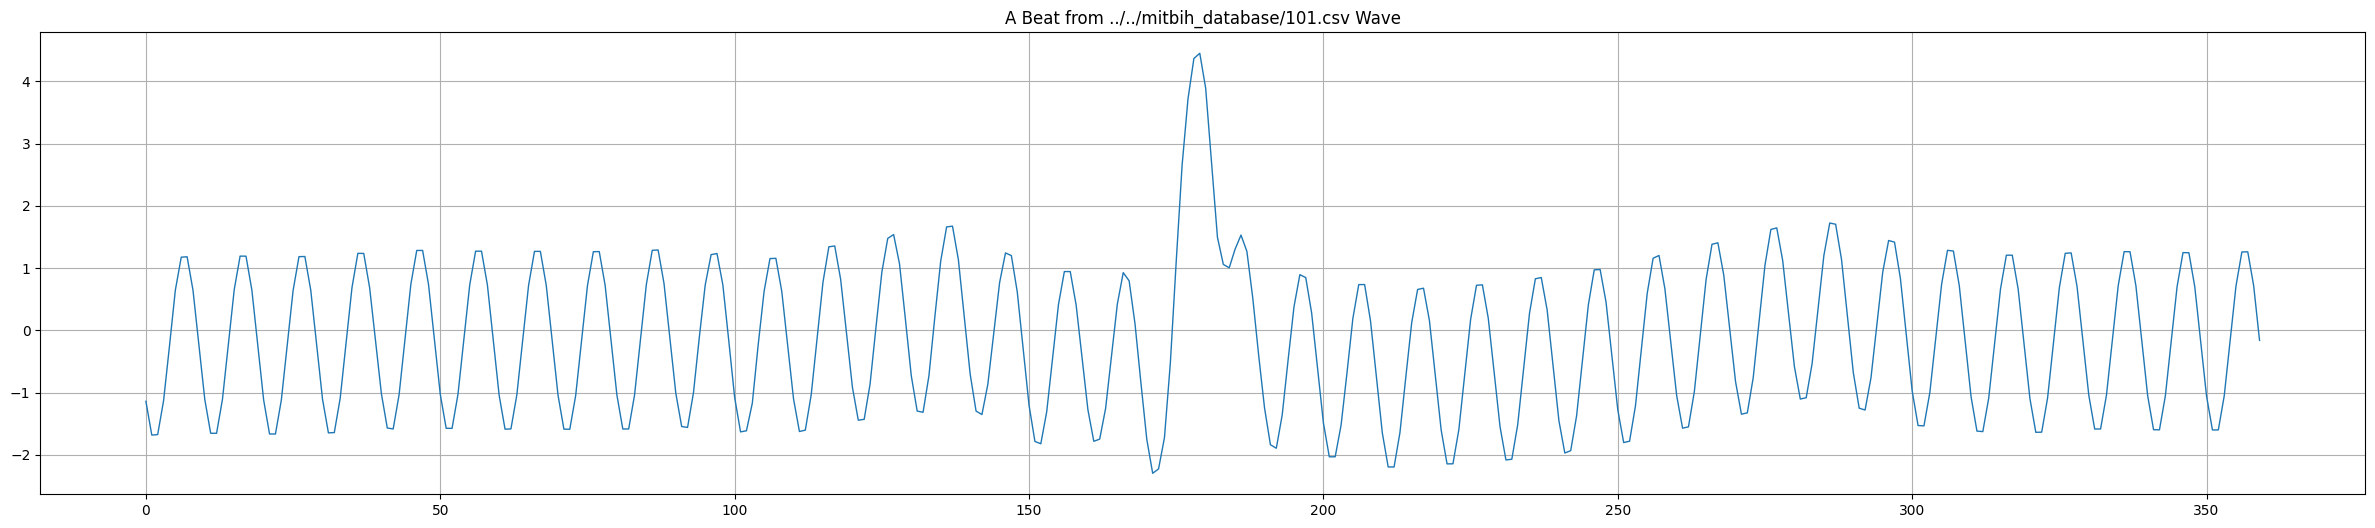

(100012, 360) (100012,)


In [31]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:200])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:200])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:200])
        plt.show()
    
    # 싸이너스 노이즈 파형을 생성합니다.
    frequency = 10  # 노이즈 주파수 = 높은 주파수는 빠르게 = 속도 결정
    amplitude = 1.5  # 노이즈 진폭 = 노이즈의 크기
    phase = 0  # 노이즈 위상 = 파형의 시작점
    t = np.arange(0, len(signals)/100 ,0.01)


    sinusoid_noise = amplitude * np.sin(2 * np.pi * frequency * t + phase)

    # 원본 ECG 데이터에 싸이너스 노이즈를 추가합니다.
    signals = signals + sinusoid_noise

    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after add sinusoid noise ")
        plt.plot(signals[0:200])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [32]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


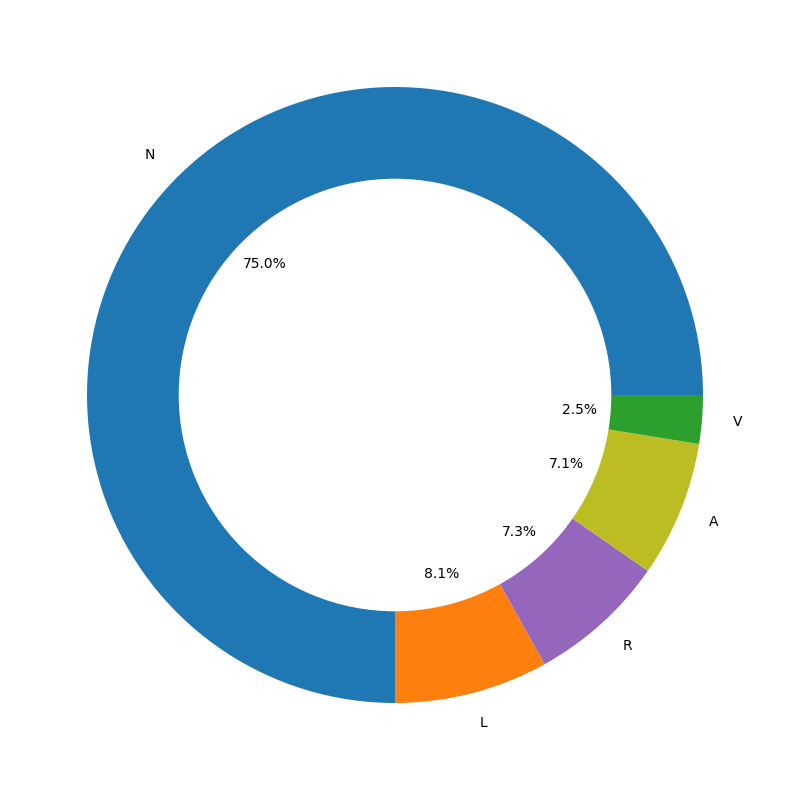

In [33]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [34]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


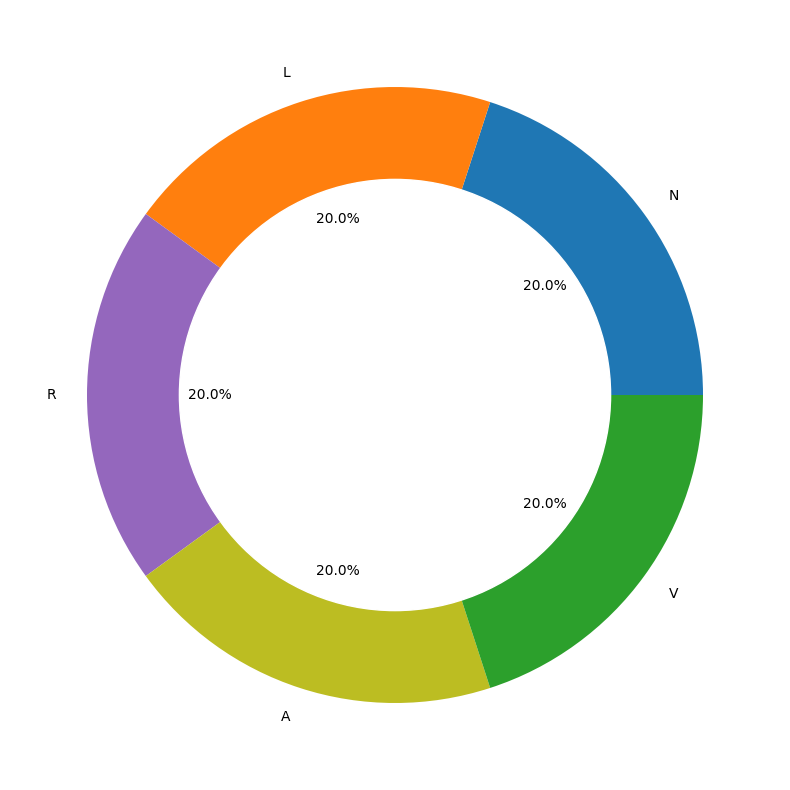

In [35]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [36]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [37]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [38]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [39]:
model = Sequential()

model.add(LSTM(32, return_sequences=True, activation='tanh', input_shape=(360,1)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 360, 32)           4352      
                                                                 
 lstm_5 (LSTM)               (None, 360, 64)           24832     
                                                                 
 lstm_6 (LSTM)               (None, 360, 64)           33024     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 97477 (380.77 KB)
Trainable params: 9747

## Compiling the model

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [41]:
print(train_x.shape)

(20000, 360, 1)


## Fitting the model

In [42]:
history = model.fit(train_x, train_y, batch_size=32, epochs=25, verbose=1, validation_data=(test_x, test_y))

Epoch 1/25
625/625 [==============================] - 169s 262ms/step - loss: 1.3756 - accuracy: 0.4175 - val_loss: 1.3123 - val_accuracy: 0.4932
Epoch 2/25
625/625 [==============================] - 155s 249ms/step - loss: 1.0694 - accuracy: 0.5896 - val_loss: 0.9154 - val_accuracy: 0.6606
Epoch 3/25
625/625 [==============================] - 153s 245ms/step - loss: 0.9298 - accuracy: 0.6544 - val_loss: 0.8503 - val_accuracy: 0.6822
Epoch 4/25
625/625 [==============================] - 154s 246ms/step - loss: 0.7697 - accuracy: 0.7242 - val_loss: 0.6204 - val_accuracy: 0.7800
Epoch 5/25
625/625 [==============================] - 154s 246ms/step - loss: 0.8727 - accuracy: 0.6786 - val_loss: 0.9117 - val_accuracy: 0.6644
Epoch 6/25
625/625 [==============================] - 154s 247ms/step - loss: 1.3125 - accuracy: 0.4541 - val_loss: 1.0353 - val_accuracy: 0.6220
Epoch 7/25
625/625 [==============================] - 153s 245ms/step - loss: 0.9921 - accuracy: 0.6368 - val_loss: 0.9144 -

**Plotting the loss convergence**

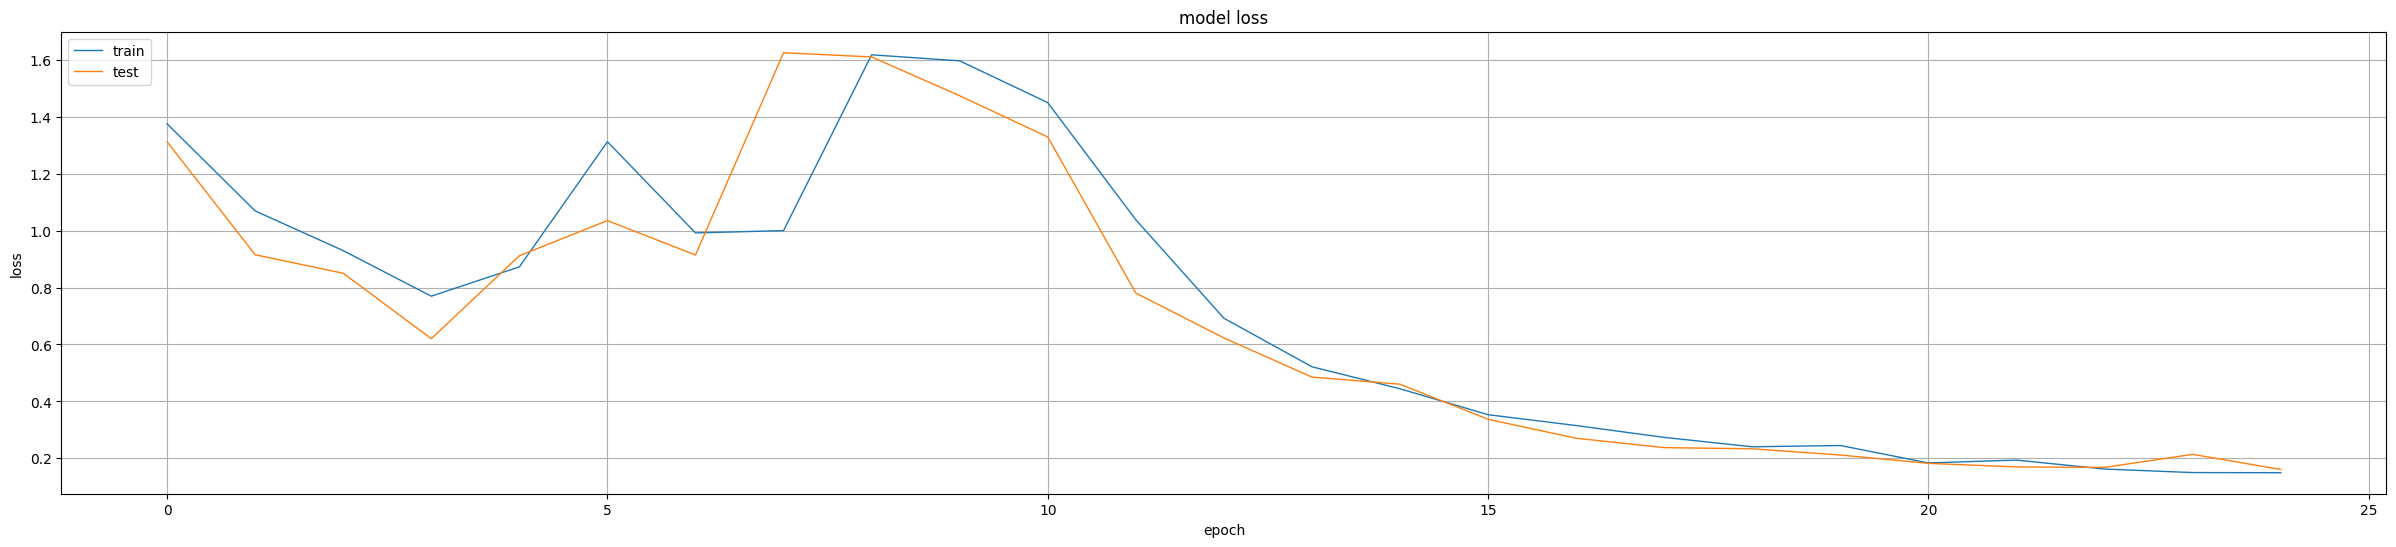

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

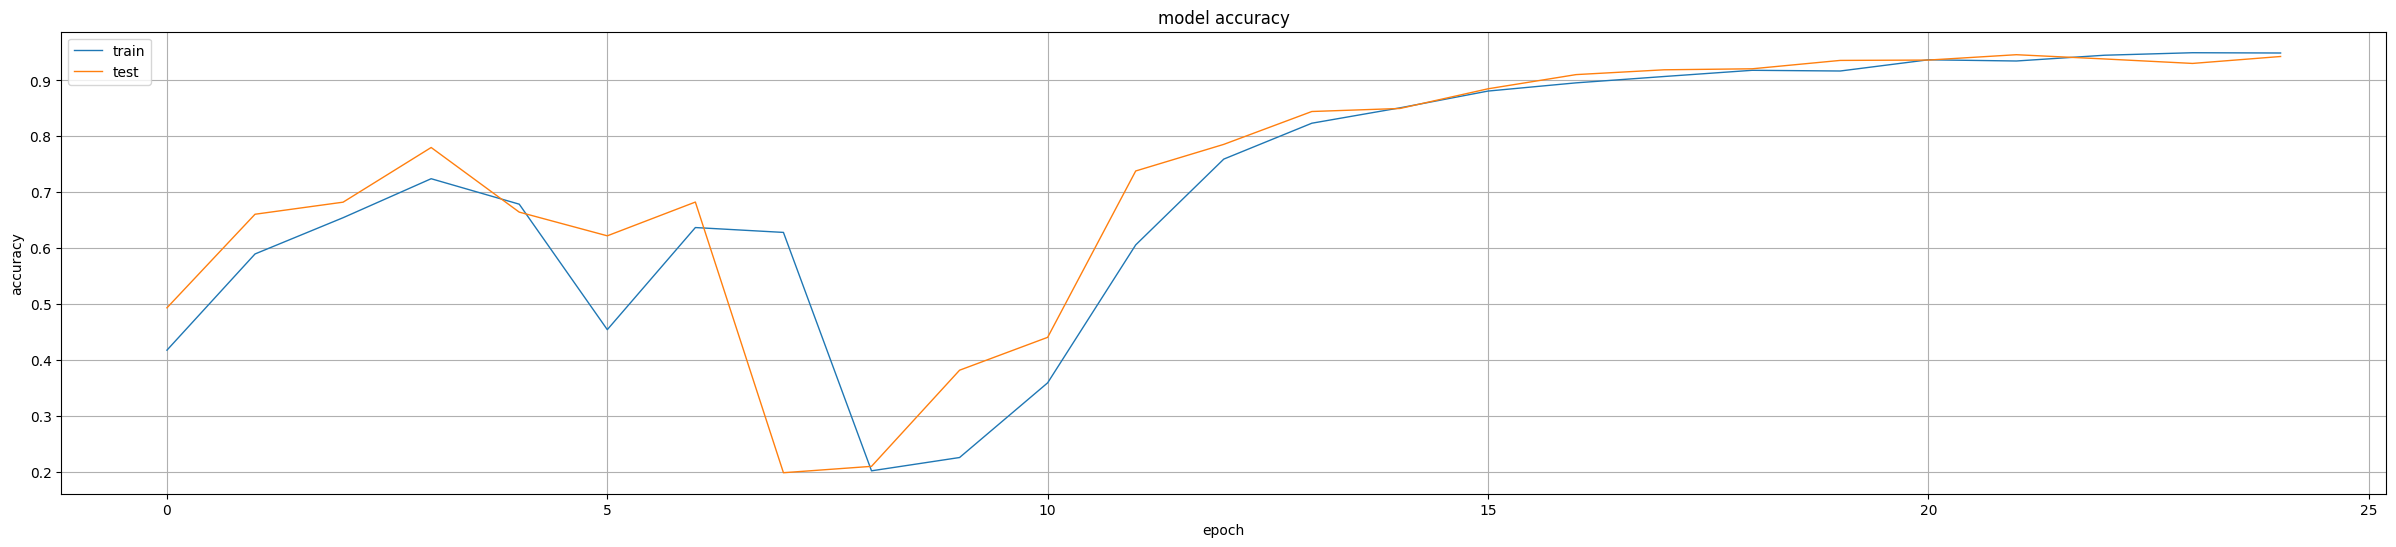

In [44]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [45]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 15s 93ms/step - loss: 0.1609 - accuracy: 0.9428
Test Loss: 0.16087979078292847
Test accuracy: 0.942799985408783


In [46]:
model.save('LSTM_sin2.h5')

c:\Users\root\anaconda3\envs\mit\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
